<a href="https://colab.research.google.com/github/hyakuroume/Generative_AI/blob/develop/compressing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q genaibook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 137.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


## データの準備

In [4]:
from datasets import load_dataset

# MINSITデータセットのロード
mnist = load_dataset("mnist")
mnist

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
# 28pixel*28pixelの手書き数字の画像
mnist["train"]["image"][0]

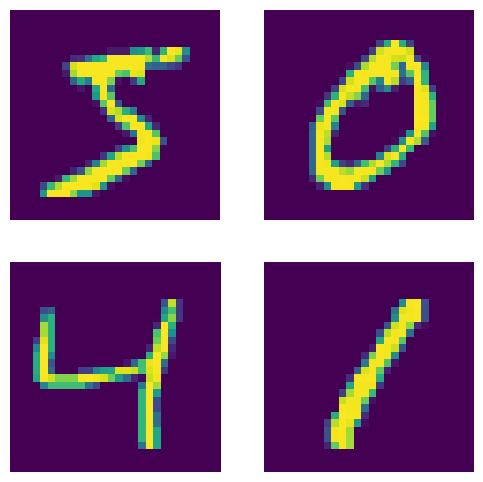

In [6]:
# 高解像度で表示
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

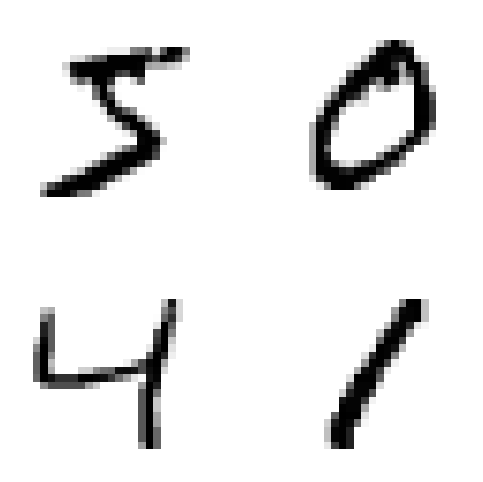

In [7]:
# 白黒で表示
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"
show_images(mnist["train"]["image"][:4])

In [8]:
from torchvision import transforms

def mnist_to_tensor(samples):
    """
    mnistデータセットを受け取り、PyTorchテンソルに変換する

    Args:
        samples (dict): mnistデータセットのサンプル

    Returns:
        dict: PyTorchテンソルに変換されたサンプル
    """
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [9]:
# データをPyTorchテンソルに変換し、訓練データセットをシャッフル
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [10]:
# データの確認(0~1の範囲になっているか)
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

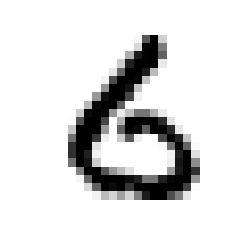

In [11]:
show_images(mnist["train"]["image"][0])

In [12]:
# DataLoaderの作成
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

## エンコーダーのモデリング

In [13]:
from torch import nn

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        ),

        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # バッチの次元数を保持したまま平坦化
        x = self.linear(x.flatten(start_dim=1))
        return x

In [15]:
# サイズの確認
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [16]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [17]:
encoded

tensor([[ 2.4254e-02, -4.3659e-04,  9.5598e-04, -2.8590e-02, -5.5946e-03,
         -2.0903e-02, -1.6663e-02, -1.6515e-03, -1.5799e-02,  1.2399e-02,
          2.5017e-02,  1.4055e-03, -2.6913e-03,  2.0417e-02, -2.0797e-02,
         -2.4902e-06]], grad_fn=<AddmmBackward0>)

In [18]:
# バッチに対応できているか確認
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels)(batch)

batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

## デコーダー

In [19]:
def conv_transposed_block(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=0,
        with_act=True
):
    """
    転地畳み込み

    Args:
        in_channels (int): 入力チャネル数
        out_channels (int): 出力チャネル数

    Return:
        nn.Sequential: 転地畳み込み層のレイヤーブロック
    """

    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]

    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())

    return nn.Sequential(*modules)

In [20]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.linear = nn.Linear(16, 1024 * 4 * 4)
        self.t_conv1 = conv_transposed_block(1024, 512)
        self.t_conv2 = conv_transposed_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transposed_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))

        x = self.t_conv1(x)
        x = self.t_conv2(x)
        x = self.t_conv3(x)

        return x

In [21]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

## 訓練

In [22]:
class AutoEncoder(nn.Module):
    """
    エンコーダとデコーダーを直列につないだモデル
    """
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [23]:
# モデルの定義
model = AutoEncoder(1)

In [24]:
# 各レイヤーのパラメータ数や出力形状の確認
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [25]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange
from genaibook.core import get_device

In [26]:
# エポック数と学習率の定義
num_epochs = 10
lr = 1e-4

In [27]:
device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

In [28]:
losses = []

for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
        batch = batch.to(device)

        # モデルの予測
        preds = model(batch)

        # 予測と元画像の比較
        loss = F.mse_loss(preds, batch)

        # 損失を表示し、描画用に保存
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        # 損失に基づいてモデルのパラメータを更新
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


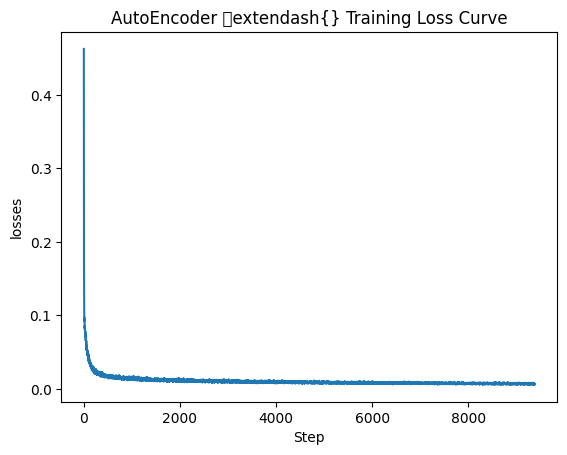

In [29]:
# 損失曲線の可視化
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("losses")
plt.title("AutoEncoder \textendash{} Training Loss Curve")
plt.show()

In [30]:
# 評価用のデータローダーの作成
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [31]:
# 評価モードにして予測
model.eval()

with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

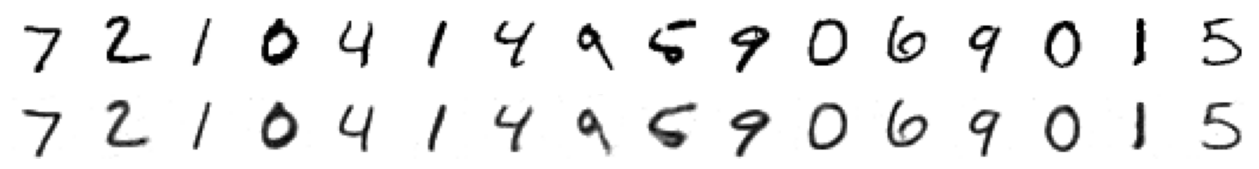

In [32]:
# 元の画像と予測画像の比較
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## 潜在空間の探索

- 潜在空間の次元をハイパーパラメータに含める
- 畳み込み層をnn.Sequentialにまとめる
- 活性化関数をシグモイド関数に変更

In [33]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        self.linear = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

In [40]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()

        self.linear = nn.Linear(latent_dims, 1024*4*4)
        self.t_conv_layers = nn.Sequential(
            conv_transposed_block(1024, 512),
            conv_transposed_block(512, 256, output_padding=1),
            conv_transposed_block(256, out_channels, output_padding=1, with_act=False),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [41]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [42]:
def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()
    losses = []

    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
            batch = batch.to(device)

            # モデルに渡して別の画像セットを取得
            preds = model(batch)

            # 予測結果と元画像を比較
            loss = F.mse_loss(preds, batch)

            # 損失を表示し、描画用に保存
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())

            # 損失に基づいてモデルのパラメータを表示
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

    return losses

In [43]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [45]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

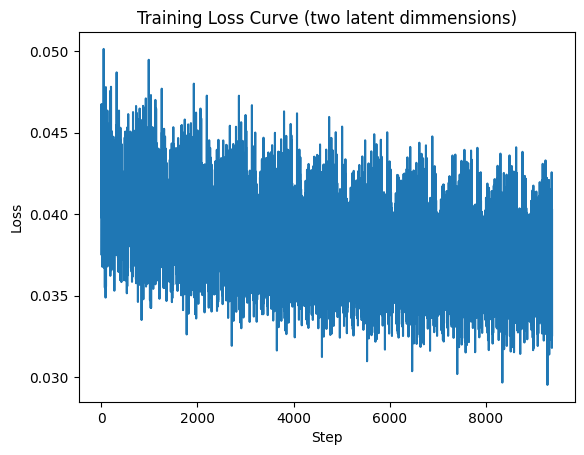

In [46]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimmensions)")
plt.show()

In [48]:
ae_model.eval()

with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

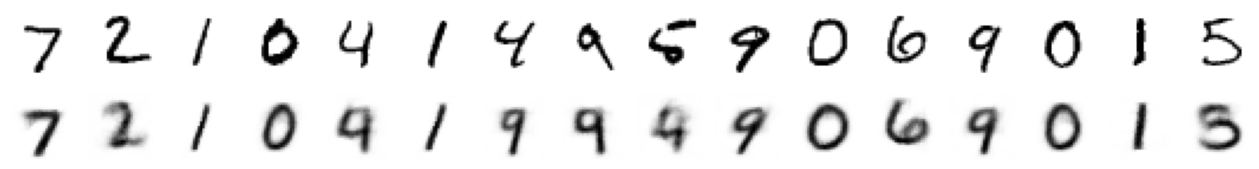

In [49]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)